In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!apt install subversion


In [ ]:
rm -rf '/content/cpm_tutorial'

In [ ]:
!svn checkout https://github.com/esfinn/cpm_tutorial/trunk


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True



In [ ]:

batch_size = 512
epochs = 20
learning_rate = 1e-3


In [ ]:

top_dir = Path("/content/trunk/fc_data/")
data_dir = Path("/content/trunk/fc_data/")

subj_list = pd.read_csv('/content/trunk/unrelated_subIDs_n337.txt', header=None)
subj_list = np.array(subj_list, dtype=str).flatten()

all_behav_data = pd.read_csv('/content/trunk/unrestricted_behav_data_n337.csv', dtype={'Subject': str})
all_behav_data.set_index('Subject', inplace=True)



In [ ]:
#data and preprocessing step sadapted from https://github.com/esfinn/cpm_tutorial/trunk

def read_in_matrices(subj_list, file_suffix=None, data_dir=data_dir, zscore=False):
    """
    Reads in a set of individual-subject connectivity matrices stored in data_dir,
    
    Returns a dataframe that is subjects x edges (by vectorizing the upper triangle of each FC matrix).
    
    Assumes:
    - each matrix is stored in a separate file beginning with the subject ID, and
    - matrices are symmetric (squareform); i.e., for a parcellation with 268 nodes, matrices should be 268 x 268
    """
    
    all_fc_data = {}
            
    for subj in subj_list:
        # try to find this subject's matrix
        if file_suffix:
            file = [f for f in os.listdir(data_dir) if subj in f and file_suffix in f]
        else:
            file = [f for f in os.listdir(data_dir) if subj in f]
            
        # make sure there is one and only one file    
        if len(file) ==0:
            raise ValueError("No data found for subject {}".format(subj))
        if len(file) >1:
            raise ValueError("More than one matrix found for subject {}! Specify a suffix?".format(subj))
        
        # read it in and make sure it's symmetric and has reasonable dimensions
        tmp = np.loadtxt(data_dir / file[0])
        assert tmp.shape[0]==tmp.shape[1]>1, "Matrix seems to have incorrect dimensions: {}".format(tmp.shape)
        
        # take just the upper triangle and store it in a dictionary
        if ~zscore:
            all_fc_data[subj] = tmp[np.triu_indices_from(tmp, k=1)]
        if zscore:
            all_fc_data[subj] = sp.stats.zscore(tmp[np.triu_indices_from(tmp, k=1)])
        
    # Convert dictionary into dataframe
    all_fc_data = pd.DataFrame.from_dict(all_fc_data, orient='index')
    
    return all_fc_data


In [ ]:
rest_fc_data = read_in_matrices(subj_list, file_suffix='REST')
wm_fc_data = read_in_matrices(subj_list, file_suffix='WM')

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class CustomTextDataset(Dataset):
    def __init__(self, rest, wm):
        self.rest = rest
        self.wm = wm
def __len__(self):
        return len(self.rest)
def __getitem__(self, idx):
        label = self.rest[idx]
        text = self.wm[idx]
        sample = {"rest": rest, "wm": wm}
        return sample

In [ ]:
sp.spatial.distance.squareform(rest_fc_data.iloc[0,:])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, rest_fc_data, wm_fc_data):
        self.rest_fc_data = rest_fc_data
        self.wm_fc_data = wm_fc_data


    def __getitem__(self, index):
        full_rest = sp.spatial.distance.squareform(rest_fc_data.iloc[index,:])
        full_wm = sp.spatial.distance.squareform(wm_fc_data.iloc[index,:])
        
        r, w = torch.from_numpy(full_rest), torch.from_numpy(full_wm)
        return r,w

    def __len__(self):
        return len(self.image_paths)

In [ ]:
import glob
from sklearn import model_selection

files=glob.glob('/content/trunk/fc_data/*_REST1*') #read in the files

test_set_size = 0.2
#create training and validation stages and split the files appropriately between them
phases={}

phases["train"],phases["val"]=next(iter(model_selection.ShuffleSplit(n_splits=5,test_size=test_set_size).split(files)))


In [ ]:
train_files = []
val_files = []

for i in range(len(phases["train"])):
    train_files.append(files[phases["train"][i]][23:29])
for i in range(len(phases["val"])):
    val_files.append(files[phases["val"][i]][23:29])


In [ ]:

TRAINSET_SIZE = len(train_files)
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(val_files)
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 271 images.
The Validation Dataset contains 68 images.


In [ ]:
rest_train = []
rest_test = []
wm_train = []
wm_test = []
for item in range(0,271):
  print(item)
  rest_train.append(sp.spatial.distance.squareform(rest_fc_data.iloc[item,:]))
  wm_train.append(sp.spatial.distance.squareform(wm_fc_data.iloc[item,:]))
for item in range(271,337):
  print(item)
  rest_test.append(sp.spatial.distance.squareform(rest_fc_data.iloc[item,:]))
  wm_test.append(sp.spatial.distance.squareform(wm_fc_data.iloc[item,:]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_x = torch.Tensor(np.asarray(rest_train)) # transform to torch tensor
train_y = torch.Tensor(np.asarray(wm_train))

train_dataset = TensorDataset(train_x,train_y) # create your datset
train_loader = DataLoader(my_dataset) # create your dataloader

test_x = torch.Tensor(np.asarray(rest_test)) # transform to torch tensor
test_y = torch.Tensor(np.asarray(wm_test))

test_dataset = TensorDataset(test_x,test_y) # create your datset
test_loader = DataLoader(test_dataset) # create your dataloader

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=268).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()


In [ ]:

for epoch in range(10):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 268).to(device)

        optimizer.zero_grad()
        
        outputs = model(batch_features)
        
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        
        optimizer.step()
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))



In [ ]:

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 268)
        reconstruction = model(test_examples)
        break



In [ ]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

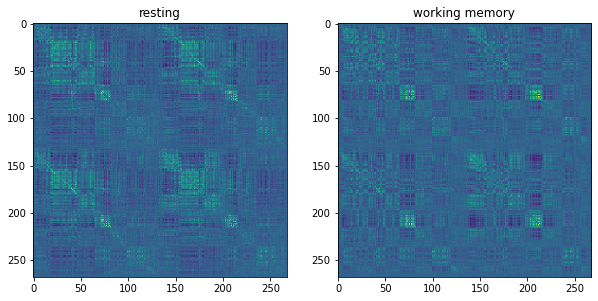

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('resting')
plt.imshow(np.asarray(rest_train)[0])
plt.subplot(1,2,2)
plt.title('working memory')
plt.imshow(np.asarray(wm_train)[0])

In [ ]:
train_r = []
train_w = []

for i in range(len(rest_train)):
  img1 = np.zeros( ( np.array(rest_train[i]).shape[0], np.array(rest_train[i]).shape[1], 3 ) )
  img1[:,:,0] = rest_train[i] # same value in each channel
  img1[:,:,1] = rest_train[i]
  img1[:,:,2] = rest_train[i]
  train_r.append(img1)
  img2 = np.zeros( ( np.array(wm_train[i]).shape[0], np.array(wm_train[i]).shape[1], 3 ) )
  img2[:,:,0] = wm_train[i] # same value in each channel
  img2[:,:,1] = wm_train[i]
  img2[:,:,2] = wm_train[i]
  train_w.append(img2)
test_r = []
test_w = []

for i in range(len(rest_test)):
  img1 = np.zeros( ( np.array(rest_test[i]).shape[0], np.array(rest_test[i]).shape[1], 3 ) )
  img1[:,:,0] = rest_test[i] # same value in each channel
  img1[:,:,1] = rest_test[i]
  img1[:,:,2] = rest_test[i]
  test_r.append(img1)
  img2 = np.zeros( ( np.array(wm_test[i]).shape[0], np.array(wm_test[i]).shape[1], 3 ) )
  img2[:,:,0] = wm_test[i] # same value in each channel
  img2[:,:,1] = wm_test[i]
  img2[:,:,2] = wm_test[i]
  test_w.append(img2)


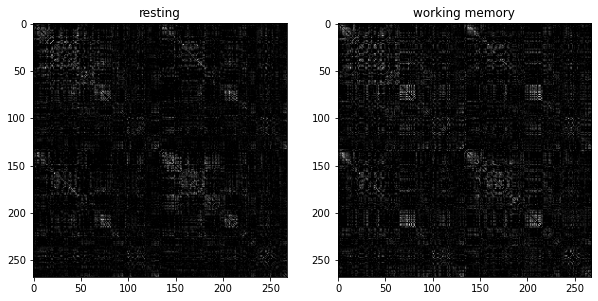

In [ ]:

figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('resting')
plt.imshow(np.asarray(test_r)[0])
plt.subplot(1,2,2)
plt.title('working memory')
plt.imshow(np.asarray(test_w)[0])

In [ ]:
SIZE =268
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(268,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(6, 6))(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
  
    return tf.keras.Model(encoder_input, decoder_output)

        
    

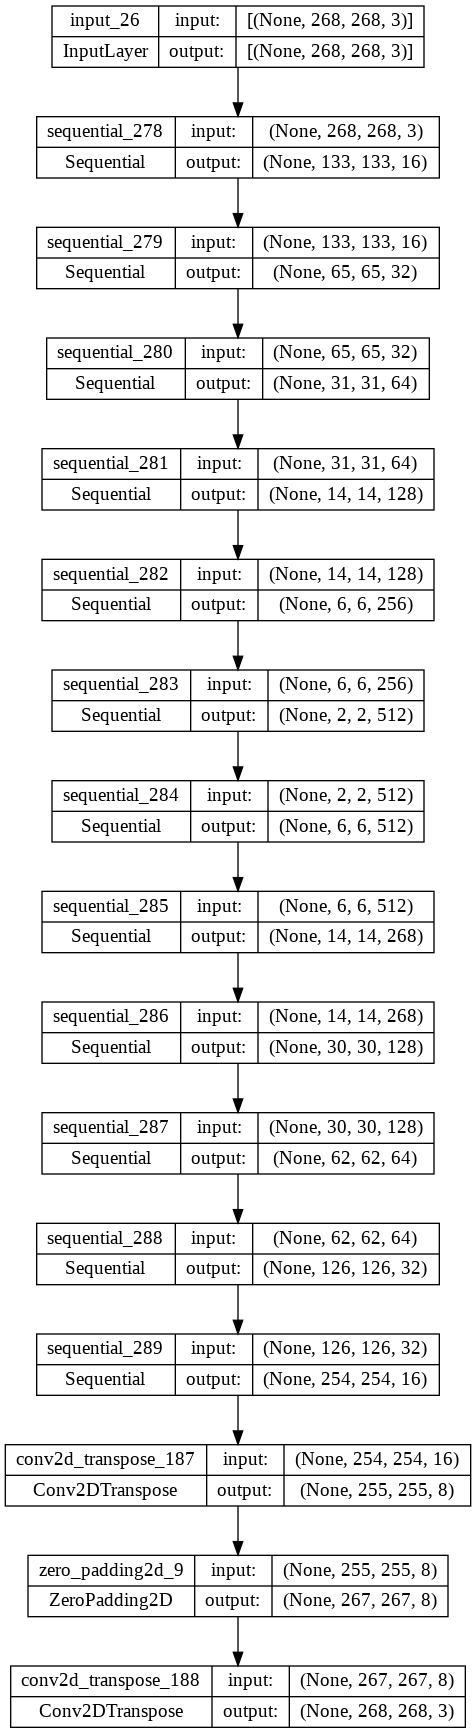

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
# to get summary of model
model = model()
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 268, 268, 3)]     0         
                                                                 
 sequential_278 (Sequential)  (None, 133, 133, 16)     768       
                                                                 
 sequential_279 (Sequential)  (None, 65, 65, 32)       8320      
                                                                 
 sequential_280 (Sequential)  (None, 31, 31, 64)       32768     
                                                                 
 sequential_281 (Sequential)  (None, 14, 14, 128)      131584    
                                                                 
 sequential_282 (Sequential)  (None, 6, 6, 256)        525312    
                                                                 
 sequential_283 (Sequential)  (None, 2, 2, 512)        209

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(np.asarray(train_r), np.asarray(train_w), epochs = 50, verbose = 0)
model.save('/conent/gdrive/newmodel')

In [ ]:
max(history.history['acc'])

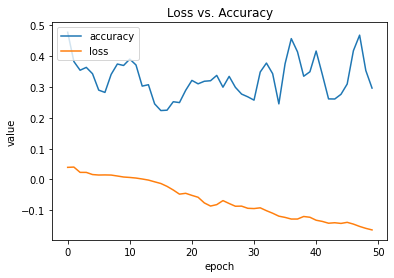

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Loss vs. Accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [ ]:
prediction_on_test_data = model.evaluate(np.asarray(test_r), np.asarray(test_w))
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

3/3 [==============================] - 7s 2s/step - loss: -0.1467 - acc: 0.2796
Loss:  -0.14674708247184753
Accuracy:  28.0


In [ ]:
def show_images(rest,wm, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Resting",fontsize = 15)
    plt.imshow(rest)
    plt.subplot(1,3,2)
    plt.title("Working Memory",fontsize = 15)
    plt.imshow(wm)
    plt.subplot(1,3,3)
    plt.title("Predicted Working Memory",fontsize = 15)
    plt.imshow(predicted)

In [ ]:
ls = [i for i in range(0,66,10)]
for i in ls:
    predicted =np.clip(model.predict(test_r[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_r[i],test_w[i],predicted)